<a href="https://colab.research.google.com/github/stevecrawshaw/hackathon/blob/main/Copy_of_hackathon_eda_sc_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # !pip install --upgrade geopandas pyshp shapely descartes

In [ ]:
 # !pip install --upgrade pandas_profiling


In [ ]:
 # !pip install --upgrade geoplot

In [46]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geoplot as gp
from pandas_profiling import ProfileReport # only works on UBUNTU!
import matplotlib.pyplot as plt
%matplotlib inline

### Health Data
Looks like this is a DF of health establishments detailing the facilities available and some location data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# !ls -l

In [47]:
health_df_raw = pd.read_csv('health.csv', index_col = 'facility_name')

In [ ]:
# health_df_raw.head()

In [48]:
health_profile = ProfileReport(health_df_raw, title = "Health Facility EDA Report") # some sort of pandas incompatability error (works on ubuntu)

In [ ]:
# health_profile

In [ ]:
health_df_raw.head()

### COVID cases: Dates, locations and patient details for COVID cases
dates need parsing

In [49]:
covid_df_raw = pd.read_csv('https://raw.githubusercontent.com/dsfsi/covid19africa/master/data/line_lists/line-list-nigeria.csv',
                          index_col = ['case_id'])

In [50]:
covid_df_raw.head(3)

,origin_case_id,date,age,gender,city,province/state,country,current_status,source,symptoms,date_onset_symptoms,date_admission_hospital,date_confirmation,underlying_conditions,travel_history_dates,travel_history_location,death_date,notes_for_discussion,Unnamed: 19
case_id,,,,,,,,,,,,,,,,,,,
1,NaN,2/27/2020,44,Male,Ogun,Ogun,Nigeria,In recovery,www.bbc.com,NaN,NaN,2/27/2020,27-Feb-20,No,NaN,Italy,NaN,Patient came in from Italy.,NaN
2,NaN,03/09/2020,NaN,NaN,Ogun,Ogun,Nigeria,In treatment,https://twitter.com/NCDCgov/status/12376418124...,NaN,03/09/2020,03/09/2020,03/09/2020,No,NaN,NaN,NaN,NaN,NaN
3,NaN,3/16/2020,30,Female,Lagos,Lagos,Nigeria,Clinically Stable,https://twitter.com/NCDCgov/status/12398485450...,"Fever, Cold, Cough",NaN,3/17/2020,3/17/2020,NaN,13-Mar-20,United Kingdom,NaN,Patient returned from trip to UK and was in 14...,NaN


In [51]:
covid = covid_df_raw.copy()

covid['date'] = pd.to_datetime(covid_df_raw['date'])

In [52]:
covid.set_index('date', inplace=True)

In [53]:
covid_profile = ProfileReport(covid, title = 'Covid Data Report')

In [54]:
# covid_profile

Text(0.5, 1.0, 'Cases by Date')

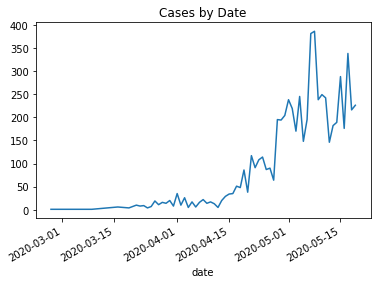

In [55]:
ax = covid.groupby('date').count().country.plot();
ax.set_title('Cases by Date')

### Population data


In [56]:
# read data from files
nga_adm0_2020_df_raw = pd.read_csv('https://data.humdata.org/dataset/a7c3de5e-ff27-4746-99cd-05f2ad9b1066/resource/4710c51c-813b-481f-bb4e-ffb593e6f126/download/nga_admpop_adm0_2020.csv')
nga_adm1_2020_df_raw = pd.read_csv('https://data.humdata.org/dataset/a7c3de5e-ff27-4746-99cd-05f2ad9b1066/resource/d9fc551a-b5e4-4bed-9d0d-b047b6961817/download/nga_admpop_adm1_2020.csv')
nga_adm2_2020_df_raw = pd.read_csv('https://data.humdata.org/dataset/a7c3de5e-ff27-4746-99cd-05f2ad9b1066/resource/562e7757-0683-4d61-87bd-a7c94af2ee38/download/nga_admpop_adm2_2020.csv')


#### WHOLE COUNTRY


In [58]:
nga_adm0_2020_df_raw

,ADM0_NAME,ADM0_PCODE,F_TL,M_TL,T_TL,F_00_04,F_05_09,F_10_14,F_15_19,F_20_24,...,T_35_39,T_40_44,T_45_49,T_50_54,T_55_59,T_60_64,T_65_69,T_70_74,T_75_79,T_80Plus
0,NIGERIA,NG,100473260,104435960,204909220,15713253,13740497,12305947,10974474,9109497,...,11462880,9544981,7514275,5941812,4697628,3586657,2691997,1907879,1142924,752680


#### ADMIN LEVEL 1

In [59]:
nga_adm1_2020_df_raw.ADM1_NAME.unique()

array(['ABIA', 'ADAMAWA', 'AKWA IBOM', 'ANAMBRA', 'BAUCHI', 'BAYELSA',
       'BENUE', 'BORNO', 'CROSS RIVER', 'DELTA', 'EBONYI', 'EDO', 'EKITI',
       'ENUGU', 'FEDERAL CAPITAL TERRITORY', 'GOMBE', 'IMO', 'JIGAWA',
       'KADUNA', 'KANO', 'KATSINA', 'KEBBI', 'KOGI', 'KWARA', 'LAGOS',
       'NASARAWA', 'NIGER', 'OGUN', 'ONDO', 'OSUN', 'OYO', 'PLATEAU',
       'RIVERS', 'SOKOTO', 'TARABA', 'YOBE', 'ZAMFARA'], dtype=object)

In [60]:

# Nigeria administrative level 1 (state) 2016 projected population statistics
nga_adm1_2020_df_raw.head()

,ADM0_NAME,ADM0_PCODE,ADM1_NAME,ADM1_PCODE,F_TL,M_TL,T_TL,F_00_04,F_05_09,F_10_14,...,T_35_39,T_40_44,T_45_49,T_50_54,T_55_59,T_60_64,T_65_69,T_70_74,T_75_79,T_80Plus
0,NIGERIA,NG,ABIA,NG001,1937239,1941738,3878977,210483,215867,248705,...,222947,194133,175852,134694,126513,84071,78976,48921,35513,19470
1,NIGERIA,NG,ADAMAWA,NG002,2168252,2228347,4396599,372760,320576,273011,...,225579,188995,143381,116482,94120,72897,58057,46415,27654,17161
2,NIGERIA,NG,AKWA IBOM,NG003,2789212,2876552,5665764,326260,342223,353787,...,340402,288166,256081,190410,160830,125151,98786,53539,32155,15171
3,NIGERIA,NG,ANAMBRA,NG004,2932876,3003908,5936784,319470,334304,379733,...,350214,302323,270660,201279,185087,122166,110187,64398,48022,23577
4,NIGERIA,NG,BAUCHI,NG005,3272516,3417618,6690134,639299,509011,402259,...,322124,276823,193548,172873,109191,101830,60952,58276,31020,23856


In [61]:
nga_adm1_2020_df_raw.rename(columns={'ADM0_NAME':'Country', 'ADM1_NAME':'State', 'T_TL':'Total_Population'}, inplace=True)

In [63]:
nga_adm1_test = nga_adm1_2020_df_raw[['Country', 'State', 'Total_Population']]

nga_adm1_test.head()

,Country,State,Total_Population
0,NIGERIA,ABIA,3878977
1,NIGERIA,ADAMAWA,4396599
2,NIGERIA,AKWA IBOM,5665764
3,NIGERIA,ANAMBRA,5936784
4,NIGERIA,BAUCHI,6690134


#### ADMIN LEVEL 2

In [64]:
# Nigeria administrative level 2 (local government area) 2016 projected population statistics
nga_adm2_2020_df_raw.head(3)

,ADM0_NAME,ADM0_PCODE,ADM1_NAME,ADM1_PCODE,ADM2_NAME,ADM2_PCODE,F_TL,M_TL,T_TL,F_00_04,...,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77
0,NIGERIA,NG,ABIA,NG001,ABA NORTH,NG001001,57686,57619,115305,6388,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NIGERIA,NG,ABIA,NG001,ABA SOUTH,NG001002,185314,199626,384940,19222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NIGERIA,NG,ABIA,NG001,AROCHUKWU,NG001003,126730,128709,255439,13544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# remove extraneous columns
unnamed = nga_adm2_2020_df_raw.filter(regex='Unnamed').columns
admcols = nga_adm2_2020_df_raw.filter(regex='ADM').columns
nga_adm2_2020 = nga_adm2_2020_df_raw.drop(columns = unnamed)

In [66]:
# melt to make long
nga_adm2_2020_long = pd.melt(nga_adm2_2020,
        var_name = 'sex_age_cat',
        value_name = 'population',
        id_vars = admcols) 

In [67]:
nga_adm2_2020_long

,ADM0_NAME,ADM0_PCODE,ADM1_NAME,ADM1_PCODE,ADM2_NAME,ADM2_PCODE,sex_age_cat,population
0,NIGERIA,NG,ABIA,NG001,ABA NORTH,NG001001,F_TL,57686
1,NIGERIA,NG,ABIA,NG001,ABA SOUTH,NG001002,F_TL,185314
2,NIGERIA,NG,ABIA,NG001,AROCHUKWU,NG001003,F_TL,126730
3,NIGERIA,NG,ABIA,NG001,BENDE,NG001004,F_TL,124460
4,NIGERIA,NG,ABIA,NG001,IKWUANO,NG001005,F_TL,155278
...,...,...,...,...,...,...,...,...
41737,NIGERIA,NG,ZAMFARA,NG037,MARU,NG037010,T_80Plus,1552
41738,NIGERIA,NG,ZAMFARA,NG037,SHINKAFI,NG037011,T_80Plus,763
41739,NIGERIA,NG,ZAMFARA,NG037,TALATA MAFARA,NG037012,T_80Plus,1106
41740,NIGERIA,NG,ZAMFARA,NG037,TSAFE,NG037013,T_80Plus,1504


### Boundary geodata from Geo database

Geo data for Nigeria from ESRI Geo database  
Read the GDB into a geopandas df   
Looks like polygon boundaries for admin layers

In [68]:
# Read data
country_geodata = gpd.read_file('nga_admbnda_osgof_eha_itos.gdb', layer = 0) # country
admin_1_geodata = gpd.read_file('nga_admbnda_osgof_eha_itos.gdb', layer = 1) # ADM1
admin_2_geodata = gpd.read_file('nga_admbnda_osgof_eha_itos.gdb', layer = 2) # ADM2


In [69]:
country_geodata.head()

,admin0Name_en,admin0Pcode,admin0RefName,admin0AltName1_en,admin0AltName2_en,date,validOn,validTo,Shape_Length,Shape_Area,geometry
0,Nigeria,NG,Nigeria,None,None,2016-11-29 00:00:00+00:00,2016-12-15 00:00:00+00:00,NaT,47.959164,75.002123,"MULTIPOLYGON (((8.34482 4.61140, 8.34496 4.609..."


In [70]:

admin_1_geodata.head(2)

,admin1Name_en,admin1Pcode,admin1RefName,admin1AltName1_en,admin1AltName2_en,admin0Name_en,admin0Pcode,date,validOn,validTo,Shape_Length,Shape_Area,geometry
0,Abia,NG001,Abia,None,None,Nigeria,NG,2016-11-29 00:00:00+00:00,2016-12-15 00:00:00+00:00,NaT,4.695135,0.396543,"MULTIPOLYGON (((7.38681 6.03667, 7.38729 6.036..."
1,Adamawa,NG002,Adamawa,None,None,Nigeria,NG,2016-11-29 00:00:00+00:00,2016-12-15 00:00:00+00:00,NaT,11.525443,3.113007,"MULTIPOLYGON (((13.62129 10.94823, 13.62592 10..."


In [71]:
admin_2_geodata.head(2)

,admin2Name_en,admin2Pcode,admin2RefName,admin2AltName1_en,admin2AltName2_en,admin1Name_en,admin1Pcode,admin0Name_en,admin0Pcode,date,validOn,ValidTo,Shape_Length,Shape_Area,geometry
0,Aba North,NG001001,Aba North,None,None,Abia,NG001,Nigeria,NG,2016-11-29 00:00:00+00:00,2017-02-22 00:00:00+00:00,NaT,0.237074,0.001524,"MULTIPOLYGON (((7.40111 5.08195, 7.40013 5.082..."
1,Aba South,NG001002,Aba South,None,None,Abia,NG001,Nigeria,NG,2016-11-29 00:00:00+00:00,2017-02-22 00:00:00+00:00,NaT,0.262477,0.003531,"MULTIPOLYGON (((7.38749 5.08275, 7.38632 5.082..."


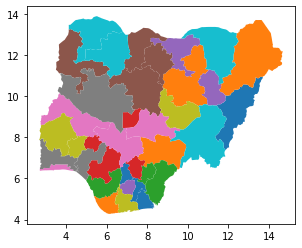

In [72]:
admin_1_geodata.plot(column = 'admin1Pcode', legend = False);

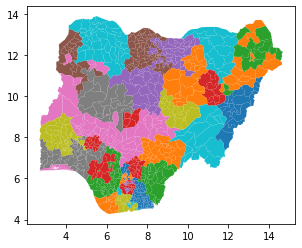

In [73]:
admin_2_geodata.plot(column = 'admin2Pcode');